In [2]:
import numpy as np
import pandas as pd
import scipy as sp
import os
import string
import glob
import re
import random

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

import matplotlib.pyplot as plt
import seaborn as sns

# 1. Wouter style preprocessing

In [3]:
files = glob.glob('../data/txt/*.txt')

In [4]:
# list of lists, so we can keep info about spelling variants in individual arrays

stops = []

with open('../data/functionwords.txt','r') as file:
    for line in file:
        words = [x for x in line.lower().split() if x != '/']
        stops.append(words)
            
print(stops[:3])

[['atqui', 'atqvi'], ['aut', 'avt'], ['autem', 'avtem']]


In [5]:
folder_path = '../data/txt'

def preprocess_text(text):
    # lowercase
    text = text.lower()
    # remove punctuation
    text = text.translate(str.maketrans("", "", string.punctuation))
    
    return text

def slice_text_into_samples(text, sample_size=1000):
    text = text.split()
    num_samples = len(text) // sample_size
    samples = [text[i * sample_size : (i + 1) * sample_size] for i in range(num_samples)]
    
    return samples

def preprocess_and_slice_text_files(folder_path, sample_size=1000):
    processed_texts = {}
    names = []
    translators = []
    for filename in os.listdir(folder_path):
        if filename.endswith(".txt"): # i'm skipping the Mysery files
            with open(os.path.join(folder_path, filename), "r", encoding='latin-1') as file:
                text = file.read()
                processed_text = preprocess_text(text)
                samples = slice_text_into_samples(processed_text, sample_size)
                num_samples = len(samples)
                for i, sample in enumerate(samples):
                    variable_name = filename[:-4] + "_" + str(i)
                    processed_texts[variable_name] = sample
            print(f"'{filename}' was processed and split into {num_samples} samples")
    return processed_texts

In [6]:
preprocess = preprocess_and_slice_text_files(folder_path)

'BurCom.txt' was processed and split into 24 samples
'AristPha.txt' was processed and split into 20 samples
'BurInt.txt' was processed and split into 64 samples
'AnonMetaph.txt' was processed and split into 61 samples
'BurEthN.txt' was processed and split into 4 samples
'BarMor.txt' was processed and split into 20 samples
'AristMet.txt' was processed and split into 6 samples
'BarMirab.txt' was processed and split into 7 samples
'WilMet.txt' was processed and split into 30 samples
'JamPhys.txt' was processed and split into 53 samples
'WilInPar.txt' was processed and split into 161 samples
'BarMun.txt' was processed and split into 5 samples
'WilTet.txt' was processed and split into 33 samples
'BarSig.txt' was processed and split into 3 samples
'AristPhaP.txt' was processed and split into 0 samples
'BarPri.txt' was processed and split into 2 samples
'WilInTim.txt' was processed and split into 4 samples
'JamMetaph.txt' was processed and split into 15 samples
'BurNemP.txt' was processed and

# 2. Chunk dataframe

In [7]:
entries = []
for k, txt in preprocess.items():
    # grab the part before the chunk number in the key, split into translator
    # and work. We need to drop empty strings that come from re.split.
    ww = [x for x in re.split('([A-Z][a-z]*)', k.split('_')[0]) if x]
    transl = ww[0]
    work = ''.join(ww[1:])
    chunk = ' '.join(txt)
    entries.append({
        'Translator' : transl,
        'Work' : work,
        'Chunk' : chunk
        })
chunk_df = pd.DataFrame(entries)
chunk_df

,Translator,Work,Chunk
0,Bur,Com,quoniam quidem ex calido et frigido et sicco e...
1,Bur,Com,sermo non quod nunquam fit in uno eodemque cor...
2,Bur,Com,horis anni invenire quartam coniugationem comp...
3,Bur,Com,quod necesse est in ea putrefieri omnia incipi...
4,Bur,Com,de ipsis per capitula quantum ad presentia uti...
...,...,...,...
1171,Bur,Fid,ostendat quod secundum veritatem est homo cum ...
1172,Bur,Fid,causative dicere ut hoc tibi soli peccavi et p...
1173,Bur,Fid,condemnavit peccatum in carne ut iustitia legi...
1174,Bur,Fid,uxorem suam et concepit et genuit quare propte...


In [8]:
set(chunk_df.Work)

{'1',
 '2',
 '3',
 '4',
 '5',
 'Alex',
 'Anim',
 'Cael',
 'Com',
 'Elem',
 'EthN',
 'EthV',
 'Fid',
 'Gen',
 'GenA',
 'His',
 'Hom',
 'InPar',
 'InTim',
 'Int',
 'Ion',
 'Mat',
 'Men',
 'Met',
 'Metaph',
 'Mirab',
 'Mor',
 'Mun',
 'P',
 'Pha',
 'Phys',
 'Pri',
 'Pue',
 'Sig',
 'Simp',
 'Tet'}

# 3. Vectorize, select only keyword freqs, merge spelling variants

In [8]:
vectorizer = TfidfVectorizer(use_idf=False, analyzer='word', decode_error='replace')
X = vectorizer.fit_transform(chunk_df.Chunk)


In [55]:
flat_stops = [item for sublist in stops for item in list(set(sublist))]


In [56]:
flat_stops

['atqui',
 'atqvi',
 'aut',
 'avt',
 'autem',
 'avtem',
 'certe',
 'cev',
 'ceu',
 'confestim',
 'cum',
 'cvm',
 'dehinc',
 'deinceps',
 'demum',
 'denique',
 'enim',
 'ergo',
 'etiam',
 'eciam',
 'exinde',
 'forsan',
 'forsitan',
 'fortassis',
 'ideo',
 'igitur',
 'igitvr',
 'ita',
 'itaque',
 'itaqve',
 'itervm',
 'iterum',
 'mox',
 'multoties',
 'multotiens',
 'mvltotiens',
 'mvltoties',
 'nam',
 'nanque',
 'namqve',
 'nanqve',
 'namque',
 'nempe',
 'nimirum',
 'nimirvm',
 'pvta',
 'puta',
 'qvando',
 'quando',
 'qvemadmodvm',
 'quemadmodum',
 'quia',
 'qvia',
 'qvidem',
 'quidem',
 'qvippe',
 'quippe',
 'quod',
 'qvod',
 'quoniam',
 'qvoniam',
 'quoque',
 'qvoqve',
 'praecipve',
 'praecipue',
 'precipue',
 'precipve',
 'rvrsvm',
 'rursum',
 'rvrsvs',
 'rursus',
 'sane',
 'scilicet',
 'sepe',
 'saepe',
 'sic',
 'sicut',
 'sicvt',
 'siquidem',
 'siqvidem',
 'tamqvam',
 'tanquam',
 'tamquam',
 'ut',
 'vt',
 'vtiqve',
 'utique',
 'velvt',
 'uelut',
 'velut',
 'velvti',
 'ueluti',
 'vel

In [76]:
v = TfidfVectorizer(use_idf=False, analyzer='word', decode_error='replace',norm='l1')
# only count our stopwords
v.fit(flat_stops)

def vectorize(s):
    # make a df with all function words
    X = v.transform([s])
    df = pd.DataFrame(X.toarray())
    df.columns = v.get_feature_names_out()

    # make a blank df
    stops_df_combined = pd.DataFrame()
    for ary in stops:
        ary = list(set(ary))
        # each array is a list of spelling variants. sum the counts for all the
        # variants that appear in the df, use the first array entry as the label
        stops_df_combined[ary[0]] = df[df.columns.intersection(ary)].sum(axis=1)
    return stops_df_combined

In [77]:
X = pd.concat([vectorize(x) for x in chunk_df.Chunk],axis=0)

In [74]:
X.shape

(1176, 54)

In [78]:
X.sum(axis=1)

0    1.0
0    1.0
0    1.0
0    1.0
0    1.0
    ... 
0    1.0
0    1.0
0    1.0
0    1.0
0    1.0
Length: 1176, dtype: float64

In [79]:
X = X.reset_index(drop=True)
X

,atqui,aut,autem,certe,cev,confestim,cum,dehinc,deinceps,demum,...,sic,sicut,siquidem,tamqvam,ut,vtiqve,velvt,velvti,uero,videlicet
0,0.0,0.030075,0.165414,0.0,0.0,0.0,0.045113,0.0,0.007519,0.0,...,0.000000,0.000000,0.000000,0.0,0.045113,0.067669,0.007519,0.0,0.067669,0.0
1,0.0,0.063830,0.184397,0.0,0.0,0.0,0.049645,0.0,0.000000,0.0,...,0.000000,0.000000,0.007092,0.0,0.070922,0.099291,0.007092,0.0,0.021277,0.0
2,0.0,0.071429,0.178571,0.0,0.0,0.0,0.000000,0.0,0.007143,0.0,...,0.014286,0.000000,0.000000,0.0,0.078571,0.042857,0.014286,0.0,0.071429,0.0
3,0.0,0.084967,0.248366,0.0,0.0,0.0,0.013072,0.0,0.000000,0.0,...,0.000000,0.000000,0.000000,0.0,0.098039,0.058824,0.000000,0.0,0.013072,0.0
4,0.0,0.224390,0.141463,0.0,0.0,0.0,0.024390,0.0,0.004878,0.0,...,0.000000,0.000000,0.000000,0.0,0.136585,0.073171,0.000000,0.0,0.024390,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1171,0.0,0.008475,0.186441,0.0,0.0,0.0,0.059322,0.0,0.000000,0.0,...,0.000000,0.000000,0.000000,0.0,0.203390,0.008475,0.000000,0.0,0.008475,0.0
1172,0.0,0.000000,0.140496,0.0,0.0,0.0,0.016529,0.0,0.000000,0.0,...,0.000000,0.000000,0.000000,0.0,0.074380,0.016529,0.008264,0.0,0.024793,0.0
1173,0.0,0.000000,0.261364,0.0,0.0,0.0,0.034091,0.0,0.000000,0.0,...,0.000000,0.011364,0.000000,0.0,0.170455,0.022727,0.011364,0.0,0.011364,0.0
1174,0.0,0.000000,0.223684,0.0,0.0,0.0,0.052632,0.0,0.000000,0.0,...,0.000000,0.026316,0.000000,0.0,0.092105,0.013158,0.000000,0.0,0.013158,0.0


In [80]:
pd.concat([chunk_df,X],axis=1)

,Translator,Work,Chunk,atqui,aut,autem,certe,cev,confestim,cum,...,sic,sicut,siquidem,tamqvam,ut,vtiqve,velvt,velvti,uero,videlicet
0,Bur,Com,quoniam quidem ex calido et frigido et sicco e...,0.0,0.030075,0.165414,0.0,0.0,0.0,0.045113,...,0.000000,0.000000,0.000000,0.0,0.045113,0.067669,0.007519,0.0,0.067669,0.0
1,Bur,Com,sermo non quod nunquam fit in uno eodemque cor...,0.0,0.063830,0.184397,0.0,0.0,0.0,0.049645,...,0.000000,0.000000,0.007092,0.0,0.070922,0.099291,0.007092,0.0,0.021277,0.0
2,Bur,Com,horis anni invenire quartam coniugationem comp...,0.0,0.071429,0.178571,0.0,0.0,0.0,0.000000,...,0.014286,0.000000,0.000000,0.0,0.078571,0.042857,0.014286,0.0,0.071429,0.0
3,Bur,Com,quod necesse est in ea putrefieri omnia incipi...,0.0,0.084967,0.248366,0.0,0.0,0.0,0.013072,...,0.000000,0.000000,0.000000,0.0,0.098039,0.058824,0.000000,0.0,0.013072,0.0
4,Bur,Com,de ipsis per capitula quantum ad presentia uti...,0.0,0.224390,0.141463,0.0,0.0,0.0,0.024390,...,0.000000,0.000000,0.000000,0.0,0.136585,0.073171,0.000000,0.0,0.024390,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1171,Bur,Fid,ostendat quod secundum veritatem est homo cum ...,0.0,0.008475,0.186441,0.0,0.0,0.0,0.059322,...,0.000000,0.000000,0.000000,0.0,0.203390,0.008475,0.000000,0.0,0.008475,0.0
1172,Bur,Fid,causative dicere ut hoc tibi soli peccavi et p...,0.0,0.000000,0.140496,0.0,0.0,0.0,0.016529,...,0.000000,0.000000,0.000000,0.0,0.074380,0.016529,0.008264,0.0,0.024793,0.0
1173,Bur,Fid,condemnavit peccatum in carne ut iustitia legi...,0.0,0.000000,0.261364,0.0,0.0,0.0,0.034091,...,0.000000,0.011364,0.000000,0.0,0.170455,0.022727,0.011364,0.0,0.011364,0.0
1174,Bur,Fid,uxorem suam et concepit et genuit quare propte...,0.0,0.000000,0.223684,0.0,0.0,0.0,0.052632,...,0.000000,0.026316,0.000000,0.0,0.092105,0.013158,0.000000,0.0,0.013158,0.0


In [9]:
# There is some encoding horror happening here, but the Latin stops won't be affected (hopefully?!)

df = pd.DataFrame(X.toarray())
df.columns = vectorizer.get_feature_names_out()
df.head()

,10,12,13,130,14,15,16,1capite,20,23,...,î½îµá,î½îµî,î½îµîºîµî½î,î½îµï,î½î½á,î½ï,î¾á½,î¾îµî¹ï,î¾îµï,ügnotum
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
flat_stops = [item for sublist in stops for item in sublist]

stops_df = df[df.columns.intersection(flat_stops)]

In [11]:
# Just our Pieter stopwords now, but not all of the (eg no 'atqvi')

stops_df

,atqui,aut,autem,avt,avtem,certe,ceu,confestim,cum,cvm,...,uidelicet,ut,utique,velut,veluti,velvt,vero,videlicet,vt,vtiqve
0,0.0,0.034605,0.190328,0.0,0.0,0.0,0.0,0.0,0.051908,0.0,...,0.0,0.051908,0.077862,0.008651,0.0,0.0,0.077862,0.0,0.0,0.0
1,0.0,0.079463,0.229559,0.0,0.0,0.0,0.0,0.0,0.061804,0.0,...,0.0,0.088292,0.123609,0.008829,0.0,0.0,0.026488,0.0,0.0,0.0
2,0.0,0.091264,0.228161,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.100391,0.054759,0.018253,0.0,0.0,0.091264,0.0,0.0,0.0
3,0.0,0.114119,0.333577,0.0,0.0,0.0,0.0,0.0,0.017557,0.0,...,0.0,0.131675,0.079005,0.000000,0.0,0.0,0.017557,0.0,0.0,0.0
4,0.0,0.371354,0.234115,0.0,0.0,0.0,0.0,0.0,0.040365,0.0,...,0.0,0.226042,0.121094,0.000000,0.0,0.0,0.040365,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1171,0.0,0.008708,0.191573,0.0,0.0,0.0,0.0,0.0,0.060955,0.0,...,0.0,0.208988,0.008708,0.000000,0.0,0.0,0.008708,0.0,0.0,0.0
1172,0.0,0.000000,0.162756,0.0,0.0,0.0,0.0,0.0,0.019148,0.0,...,0.0,0.086165,0.019148,0.009574,0.0,0.0,0.028722,0.0,0.0,0.0
1173,0.0,0.000000,0.229977,0.0,0.0,0.0,0.0,0.0,0.029997,0.0,...,0.0,0.149985,0.019998,0.009999,0.0,0.0,0.009999,0.0,0.0,0.0
1174,0.0,0.000000,0.170615,0.0,0.0,0.0,0.0,0.0,0.040145,0.0,...,0.0,0.070253,0.010036,0.000000,0.0,0.0,0.010036,0.0,0.0,0.0


In [12]:
# Now sum columns for all spelling variants, using the first word as the new column name

stops_df_combined = pd.DataFrame()
for ary in stops:
    stops_df_combined[ary[0]] = stops_df[stops_df.columns.intersection(ary)].sum(axis=1)

In [13]:
stops_df_combined

,atqui,aut,autem,certe,ceu,confestim,cum,dehinc,deinceps,demum,...,sic,sicut,siquidem,tamquam,ut,utique,velut,veluti,vero,videlicet
0,0.0,0.034605,0.190328,0.0,0.0,0.0,0.051908,0.0,0.008651,0.0,...,0.000000,0.000000,0.000000,0.0,0.051908,0.077862,0.008651,0.0,0.077862,0.0
1,0.0,0.079463,0.229559,0.0,0.0,0.0,0.061804,0.0,0.000000,0.0,...,0.000000,0.000000,0.008829,0.0,0.088292,0.123609,0.008829,0.0,0.026488,0.0
2,0.0,0.091264,0.228161,0.0,0.0,0.0,0.000000,0.0,0.009126,0.0,...,0.018253,0.000000,0.000000,0.0,0.100391,0.054759,0.018253,0.0,0.091264,0.0
3,0.0,0.114119,0.333577,0.0,0.0,0.0,0.017557,0.0,0.000000,0.0,...,0.000000,0.000000,0.000000,0.0,0.131675,0.079005,0.000000,0.0,0.017557,0.0
4,0.0,0.371354,0.234115,0.0,0.0,0.0,0.040365,0.0,0.008073,0.0,...,0.000000,0.000000,0.000000,0.0,0.226042,0.121094,0.000000,0.0,0.040365,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1171,0.0,0.008708,0.191573,0.0,0.0,0.0,0.060955,0.0,0.000000,0.0,...,0.000000,0.000000,0.000000,0.0,0.208988,0.008708,0.000000,0.0,0.008708,0.0
1172,0.0,0.000000,0.162756,0.0,0.0,0.0,0.019148,0.0,0.000000,0.0,...,0.000000,0.000000,0.000000,0.0,0.086165,0.019148,0.009574,0.0,0.028722,0.0
1173,0.0,0.000000,0.229977,0.0,0.0,0.0,0.029997,0.0,0.000000,0.0,...,0.000000,0.009999,0.000000,0.0,0.149985,0.019998,0.009999,0.0,0.009999,0.0
1174,0.0,0.000000,0.170615,0.0,0.0,0.0,0.040145,0.0,0.000000,0.0,...,0.000000,0.020072,0.000000,0.0,0.070253,0.010036,0.000000,0.0,0.010036,0.0


In [14]:
# finally, merge in the metadata columns (they can be dropped out later to make X and y arrays)

stops_tidy = pd.concat([chunk_df,stops_df_combined],axis=1)
stops_tidy

,Translator,Work,Chunk,atqui,aut,autem,certe,ceu,confestim,cum,...,sic,sicut,siquidem,tamquam,ut,utique,velut,veluti,vero,videlicet
0,Bur,Com,quoniam quidem ex calido et frigido et sicco e...,0.0,0.034605,0.190328,0.0,0.0,0.0,0.051908,...,0.000000,0.000000,0.000000,0.0,0.051908,0.077862,0.008651,0.0,0.077862,0.0
1,Bur,Com,sermo non quod nunquam fit in uno eodemque cor...,0.0,0.079463,0.229559,0.0,0.0,0.0,0.061804,...,0.000000,0.000000,0.008829,0.0,0.088292,0.123609,0.008829,0.0,0.026488,0.0
2,Bur,Com,horis anni invenire quartam coniugationem comp...,0.0,0.091264,0.228161,0.0,0.0,0.0,0.000000,...,0.018253,0.000000,0.000000,0.0,0.100391,0.054759,0.018253,0.0,0.091264,0.0
3,Bur,Com,quod necesse est in ea putrefieri omnia incipi...,0.0,0.114119,0.333577,0.0,0.0,0.0,0.017557,...,0.000000,0.000000,0.000000,0.0,0.131675,0.079005,0.000000,0.0,0.017557,0.0
4,Bur,Com,de ipsis per capitula quantum ad presentia uti...,0.0,0.371354,0.234115,0.0,0.0,0.0,0.040365,...,0.000000,0.000000,0.000000,0.0,0.226042,0.121094,0.000000,0.0,0.040365,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1171,Bur,Fid,ostendat quod secundum veritatem est homo cum ...,0.0,0.008708,0.191573,0.0,0.0,0.0,0.060955,...,0.000000,0.000000,0.000000,0.0,0.208988,0.008708,0.000000,0.0,0.008708,0.0
1172,Bur,Fid,causative dicere ut hoc tibi soli peccavi et p...,0.0,0.000000,0.162756,0.0,0.0,0.0,0.019148,...,0.000000,0.000000,0.000000,0.0,0.086165,0.019148,0.009574,0.0,0.028722,0.0
1173,Bur,Fid,condemnavit peccatum in carne ut iustitia legi...,0.0,0.000000,0.229977,0.0,0.0,0.0,0.029997,...,0.000000,0.009999,0.000000,0.0,0.149985,0.019998,0.009999,0.0,0.009999,0.0
1174,Bur,Fid,uxorem suam et concepit et genuit quare propte...,0.0,0.000000,0.170615,0.0,0.0,0.0,0.040145,...,0.000000,0.020072,0.000000,0.0,0.070253,0.010036,0.000000,0.0,0.010036,0.0


In [15]:
stops_tidy.to_csv('../data/stops_tidy.csv')

# 4. Test RandomForest with a balanced sample

Test only on the non "Mystery" files.

In [16]:
testing_df = stops_tidy[stops_tidy.Translator != 'Myst']
testing_df

,Translator,Work,Chunk,atqui,aut,autem,certe,ceu,confestim,cum,...,sic,sicut,siquidem,tamquam,ut,utique,velut,veluti,vero,videlicet
0,Bur,Com,quoniam quidem ex calido et frigido et sicco e...,0.0,0.034605,0.190328,0.0,0.0,0.0,0.051908,...,0.000000,0.000000,0.000000,0.0,0.051908,0.077862,0.008651,0.0,0.077862,0.0
1,Bur,Com,sermo non quod nunquam fit in uno eodemque cor...,0.0,0.079463,0.229559,0.0,0.0,0.0,0.061804,...,0.000000,0.000000,0.008829,0.0,0.088292,0.123609,0.008829,0.0,0.026488,0.0
2,Bur,Com,horis anni invenire quartam coniugationem comp...,0.0,0.091264,0.228161,0.0,0.0,0.0,0.000000,...,0.018253,0.000000,0.000000,0.0,0.100391,0.054759,0.018253,0.0,0.091264,0.0
3,Bur,Com,quod necesse est in ea putrefieri omnia incipi...,0.0,0.114119,0.333577,0.0,0.0,0.0,0.017557,...,0.000000,0.000000,0.000000,0.0,0.131675,0.079005,0.000000,0.0,0.017557,0.0
4,Bur,Com,de ipsis per capitula quantum ad presentia uti...,0.0,0.371354,0.234115,0.0,0.0,0.0,0.040365,...,0.000000,0.000000,0.000000,0.0,0.226042,0.121094,0.000000,0.0,0.040365,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1171,Bur,Fid,ostendat quod secundum veritatem est homo cum ...,0.0,0.008708,0.191573,0.0,0.0,0.0,0.060955,...,0.000000,0.000000,0.000000,0.0,0.208988,0.008708,0.000000,0.0,0.008708,0.0
1172,Bur,Fid,causative dicere ut hoc tibi soli peccavi et p...,0.0,0.000000,0.162756,0.0,0.0,0.0,0.019148,...,0.000000,0.000000,0.000000,0.0,0.086165,0.019148,0.009574,0.0,0.028722,0.0
1173,Bur,Fid,condemnavit peccatum in carne ut iustitia legi...,0.0,0.000000,0.229977,0.0,0.0,0.0,0.029997,...,0.000000,0.009999,0.000000,0.0,0.149985,0.019998,0.009999,0.0,0.009999,0.0
1174,Bur,Fid,uxorem suam et concepit et genuit quare propte...,0.0,0.000000,0.170615,0.0,0.0,0.0,0.040145,...,0.000000,0.020072,0.000000,0.0,0.070253,0.010036,0.000000,0.0,0.010036,0.0


In [17]:
from collections import Counter
samp_ctr = Counter(testing_df.Translator)
samp_ctr

Counter({'Bur': 371,
         'Arist': 35,
         'Anon': 66,
         'Bar': 44,
         'Wil': 554,
         'Jam': 87})

In [18]:
rf = RandomForestClassifier(n_estimators=500,
                            max_features=3,
                            n_jobs=-1
                            )

et = ExtraTreesClassifier(n_estimators=500,max_features=0.05,n_jobs=-1)

In [19]:
global_scores = []

# each time, get a balanced sample, sized at half the minimum class count
# which, for now, is 17 (Arist has 35 samples)
sample_size = min(samp_ctr.values())//2

# 100 5-fold CV runs, take average of averages, simple accuracy
for _ in range(100):
    samp = testing_df.groupby('Translator').apply(lambda x: x.sample(sample_size)).reset_index(drop=True)
    X = samp.drop(['Translator','Work','Chunk'], axis=1)
    y = samp.Translator
    scores = cross_val_score(rf, X, y, cv=5)
    global_scores.append(scores.mean())


a = np.array(global_scores)
f"{a.mean():.4%} ± {a.std() * 2:.2%}"

'96.2748% ± 3.10%'

In [20]:
global_scores = []

# each time, get a balanced sample, sized at half the minimum class count
# which, for now, is 17 (Arist has 35 samples)
sample_size = min(samp_ctr.values()) // 2

# 100 5-fold CV runs, take average of averages, simple accuracy
for _ in range(100):
    samp = testing_df.groupby('Translator').apply(lambda x: x.sample(sample_size)).reset_index(drop=True)
    X = samp.drop(['Translator','Work','Chunk'], axis=1)
    y = samp.Translator
    scores = cross_val_score(et, X, y, cv=5)
    global_scores.append(scores.mean())


a = np.array(global_scores)
f"{a.mean():.4%} ± {a.std() * 2:.2%}"

'96.6519% ± 3.18%'

In [ ]:
global_scores = []

# each time, get a balanced sample, sized at half the minimum class count
# which, for now, is 17 (Arist has 35 samples)
sample_size = min(samp_ctr.values()) // 2

# 100 5-fold CV runs, take average of averages, simple accuracy
for _ in range(100):
    samp = testing_df.groupby('Translator').apply(lambda x: x.sample(sample_size)).reset_index(drop=True)
    X = samp.drop(['Translator','Work','Chunk'], axis=1)
    y = samp.Translator
    scores = cross_val_score(et, X, y, cv=5)
    global_scores.append(scores.mean())


a = np.array(global_scores)
f"{a.mean():.4%} ± {a.std() * 2:.2%}"

'96.6519% ± 3.18%'

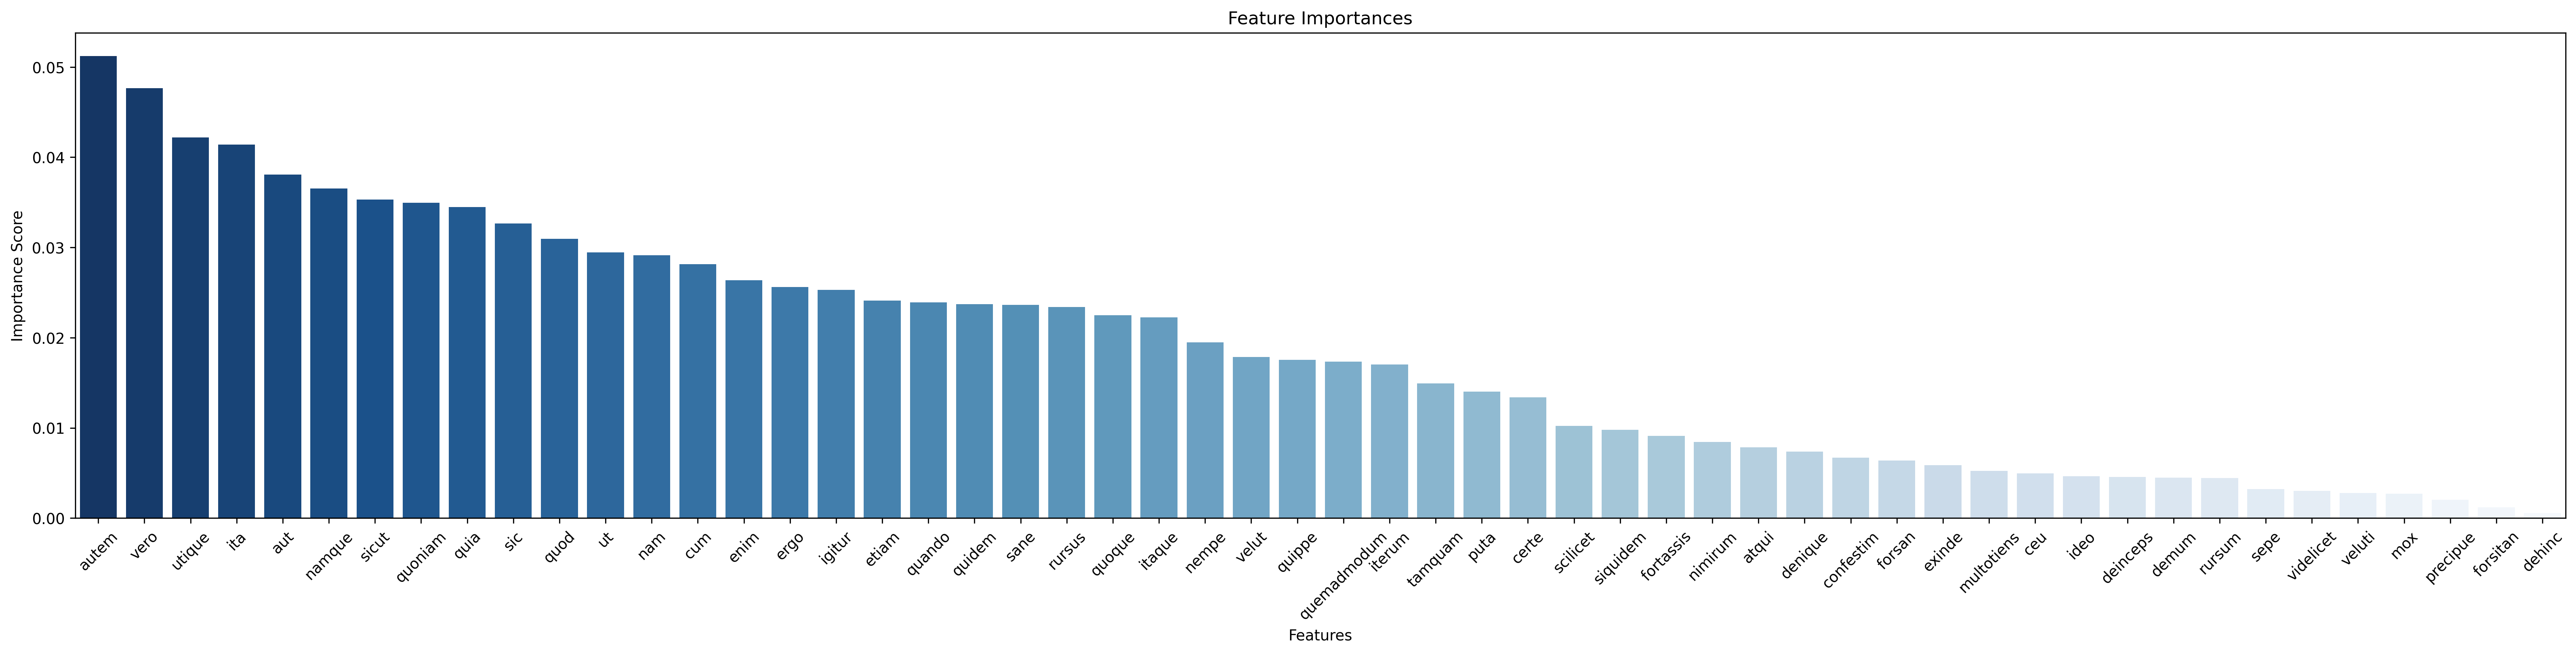

In [135]:
# Bootstrap feature importances

importances = np.zeros(len(testing_df.columns)-3)

for _ in range(100):
    samp = testing_df.groupby('Translator').apply(lambda x: x.sample(sample_size)).reset_index(drop=True)
    X = samp.drop(['Translator','Work','Chunk'], axis=1)
    y = samp.Translator
    rf.fit(X,y)
    importances += rf.feature_importances_

importances /= 100
features = testing_df.columns[3:]
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(30,6),dpi=300)
sns.barplot(x=features[indices], y=importances[indices], palette='Blues_r')
plt.xticks(rotation=45)
plt.xlabel('Features')
plt.ylabel('Importance Score')
plt.title('Feature Importances')
plt.show()

In [22]:
sample_size = min(samp_ctr.values()) // 2

feats = len(X.columns)
res = []
for i in range(2,feats+1,1):
    rf = RandomForestClassifier(n_estimators=1000,
                            max_features=i,
                            n_jobs=-1
                            )
    global_scores = []
    # each time, get a balanced sample, sized at half the minimum class count
    # which, for now, is 17 (Arist has 35 samples)
    for _ in range(10):
        samp = testing_df.groupby('Translator').apply(lambda x: x.sample(sample_size)).reset_index(drop=True)
        X = samp.drop(['Translator','Work','Chunk'], axis=1)
        y = samp.Translator
        scores = cross_val_score(rf, X, y, cv=5)
        global_scores.append(scores.mean())
    a = np.array(global_scores)
    res.append({'Feats':i, 'Acc': a.mean()})

res_df = pd.DataFrame(res)


<AxesSubplot:xlabel='Feats'>

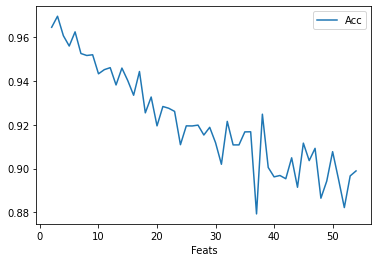

In [23]:
res_df.plot.line(x='Feats',y='Acc')

In [34]:
sample_size = min(samp_ctr.values()) // 2

res = []
for i in range(100,1150,50):
    rf = RandomForestClassifier(n_estimators=i,
                            max_features=3,
                            n_jobs=-1
                            )
    global_scores = []
    # each time, get a balanced sample, sized at half the minimum class count
    # which, for now, is 17 (Arist has 35 samples)
    for _ in range(20):
        samp = testing_df.groupby('Translator').apply(lambda x: x.sample(sample_size)).reset_index(drop=True)
        X = samp.drop(['Translator','Work','Chunk'], axis=1)
        y = samp.Translator
        scores = cross_val_score(rf, X, y, cv=5)
        global_scores.append(scores.mean())
    a = np.array(global_scores)
    res.append({'Estimators':i, 'Acc': a.mean()})

est_df = pd.DataFrame(res)


<AxesSubplot:xlabel='Estimators'>

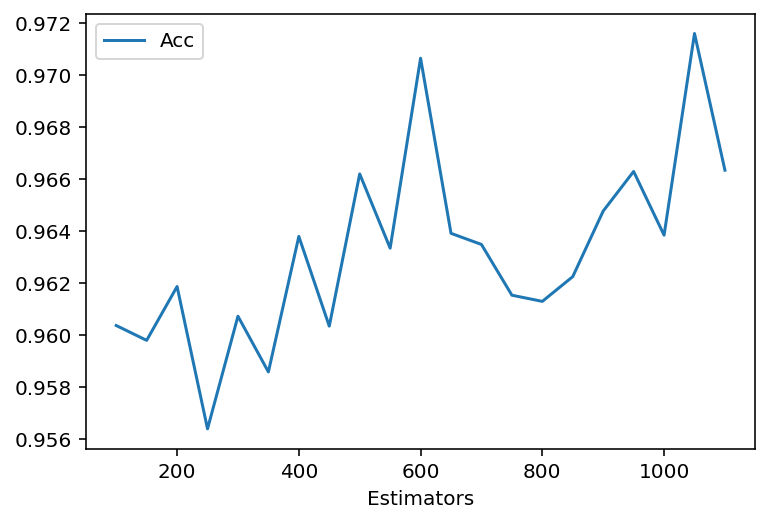

In [35]:
est_df.plot.line(y='Acc',x='Estimators')

# Bootstrap classification of Myst3.txt

In [28]:
myst_df = stops_tidy[stops_tidy.Translator == 'Myst']
myst_df

,Translator,Work,Chunk,atqui,aut,autem,certe,ceu,confestim,cum,...,sic,sicut,siquidem,tamquam,ut,utique,velut,veluti,vero,videlicet
600,Myst,5,de eo autem quod est esse alia quidem longe ui...,0.0,0.059294,0.321884,0.000000,0.0,0.000000,0.008471,...,0.042353,0.050824,0.000000,0.000000,0.050824,0.067765,0.000000,0.000000,0.059294,0.000000
746,Myst,4,non est facile dignoscere quando oportet vinde...,0.0,0.000000,0.269222,0.000000,0.0,0.021538,0.075382,...,0.010769,0.000000,0.000000,0.000000,0.096920,0.000000,0.000000,0.000000,0.107689,0.000000
747,Myst,4,est vetus autem calidissimum et fortissimum et...,0.0,0.000000,0.278411,0.000000,0.0,0.008981,0.098791,...,0.000000,0.000000,0.000000,0.000000,0.080829,0.000000,0.000000,0.000000,0.080829,0.000000
767,Myst,1,consideranti mihi o syre angulorum acceptorum ...,0.0,0.000000,0.317775,0.000000,0.0,0.000000,0.027238,...,0.000000,0.009079,0.000000,0.000000,0.127110,0.000000,0.000000,0.000000,0.000000,0.000000
768,Myst,1,servant et vocant proprie horariam pro ipsa au...,0.0,0.026796,0.303693,0.000000,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.008932,0.053593,0.017864,0.000000,0.000000,0.008932,0.000000
769,Myst,1,que ek ab l autem super eh que mln super eg au...,0.0,0.000000,0.219615,0.000000,0.0,0.000000,0.037865,...,0.000000,0.000000,0.000000,0.000000,0.022719,0.015146,0.000000,0.000000,0.022719,0.007573
770,Myst,1,in duo equa videlicet secans ipsam htk diametr...,0.0,0.000000,0.216794,0.000000,0.0,0.000000,0.015485,...,0.007743,0.000000,0.000000,0.000000,0.054198,0.015485,0.000000,0.000000,0.000000,0.015485
771,Myst,1,at s partes 23 dimidiam et tertiam ubi autem h...,0.0,0.000000,0.300105,0.000000,0.0,0.000000,0.050018,...,0.000000,0.000000,0.000000,0.000000,0.110039,0.000000,0.000000,0.000000,0.020007,0.000000
772,Myst,3,completivum ipsius existit quare et ipsum dist...,0.0,0.219694,0.261540,0.000000,0.0,0.000000,0.031385,...,0.010462,0.073231,0.000000,0.000000,0.041846,0.020923,0.000000,0.000000,0.052308,0.000000
773,Myst,3,ineptum consideratur que enim secundum proport...,0.0,0.043013,0.236573,0.000000,0.0,0.000000,0.107533,...,0.010753,0.032260,0.010753,0.000000,0.053767,0.021507,0.000000,0.010753,0.010753,0.000000


In [67]:
fn = '../data/txt/Myst3.txt'
with open(fn, 'r') as fh:
    raw = fh.read()
clean = preprocess_text(raw)
myst3 = clean.split()

In [127]:
def sample(ww, sz=1000):
    start = random.randrange(len(ww)) - sz
    return ' '.join(ww[start:start+sz])

In [101]:
v = TfidfVectorizer(use_idf=False, analyzer='word', decode_error='replace')
# only count our stopwords
v.fit(flat_stops)

def vectorize(s):
    # make a df with all function words
    X = v.transform([s])
    df = pd.DataFrame(X.toarray())
    df.columns = v.get_feature_names_out()

    # make a blank df
    stops_df_combined = pd.DataFrame()
    for ary in stops:
        # each array is a list of spelling variants. sum the counts for all the
        # variants that appear in the df, use the first array entry as the label
        stops_df_combined[ary[0]] = df[df.columns.intersection(ary)].sum(axis=1)
    return stops_df_combined

500 classifications of 1000 word sequential samples from Myst3.txt. Use 10 different classifiers, each fitted on a random balanced subsample of the training corpus.

In [111]:
c = Counter()
for _ in range(10):
    # refit the classifier on a new random sample
    samp = testing_df.groupby('Translator').apply(lambda x: x.sample(35)).reset_index(drop=True)
    X = samp.drop(['Translator','Work','Chunk'], axis=1)
    y = samp.Translator
    rf.fit(X,y)
    for _ in range(50):
        # predict for 50 samples with this classifier
        c.update(rf.predict(vectorize(sample(myst3))))

<AxesSubplot:>

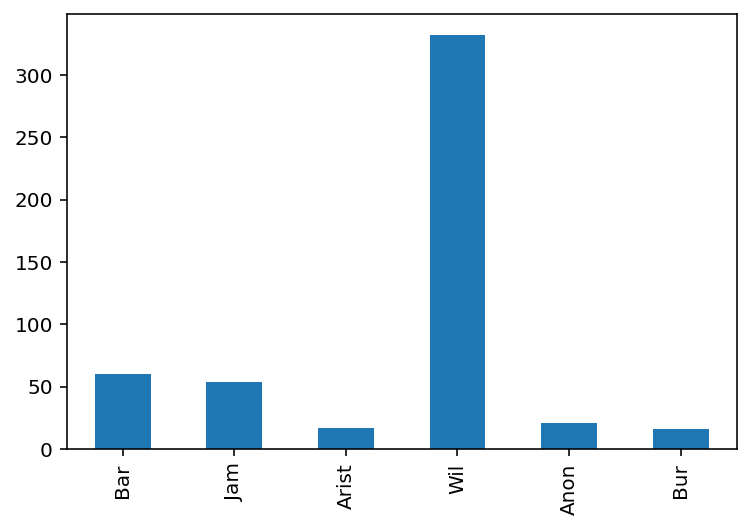

In [126]:
pd.DataFrame([c]).T.plot.bar(legend=False)